### We want to see if there is a correlation in the performance of the specific $w$ and $h(x)$ with the PR dimension of the kernel matrix.

April 28th 2020 (BP): We will use the gaussian formulation to generate our bandpass weights and the DFT matrix to generate our data

May 4th 2020 (BP): We will formulate the random white noise weights and the data using the DFT matrix. We will also constrain the weight of the weight matrix with the Trace norm

In [ ]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import dask

In [ ]:
from estimator import RFClassifier, relu, bp_weights_dft, bp_weights
from data_fns import pure_sine_dft

In [ ]:
from dask.distributed import Client
client = Client(threads_per_worker=7, n_workers=10)
client

In [4]:
def l_clf(classifier, params, X_train, y_train, X_test, y_test):
    clf = classifier(**params)
    clf.fit(X_train, y_train)
    # Estimate the Rademacher complexity
    phi = clf.transform(X_train)
    trace_K = la.norm(phi, 'fro') ** 2
    # norm of the coefficient
    clf_coef_norm = la.norm(clf.clf.coef_)
    return [trace_K, clf_coef_norm, 1 - clf.score(X_test, y_test), 1 - clf.score(X_train, y_train)]

In [34]:
def plot_results(results, title):
    fig = plt.figure(figsize=(12, 8))
    plt.suptitle(title, fontsize=16)

    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)

    ax1.set_xscale('log')
#     ax1.set_yscale('log')
    ax2.set_xscale('log')
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax4.set_xlabel('Generalization err')
    ax4.set_ylabel('Complexity ')

    ax1.set_title('Trace(K)', fontsize=16)
    ax2.set_title('clf weights norm', fontsize=16)
    ax3.set_title('Log-log plot Clf error', fontsize=16)
    ax4.set_title('Gen. err vs sqrt(Tr(K)) * |clf weights|', fontsize=16)

    for (wt, val) in results.items():
        mean_pr, mean_wt_norm, mean_test_err, mean_train_err  = np.split(np.mean(val, axis=1), 4, axis=1)
        std_pr, std_wt_norm, std_test_err, std_train_err = np.split(np.std(val, axis=1), 4, axis=1)

        val = np.array(val)
#         gen_err = val[:, :, 2] - val[:, :, 3]
#         complexity = np.sqrt(val[:, :, 0]) * val[:, :, 1]
        gen_err = mean_test_err - mean_train_err
        complexity = np.sqrt(mean_pr) * mean_wt_norm

        ax1.errorbar(n_features, mean_pr, yerr=std_pr.flatten(), fmt='--o', label=wt,  markersize=4, lw=2)
        ax2.errorbar(n_features, mean_wt_norm, yerr=std_wt_norm.flatten(), fmt='--o', label=wt, markersize=4, lw=2)
        ax3.errorbar(n_features, mean_test_err, yerr=std_test_err.flatten(), fmt='--o', label=wt, markersize=4, lw=2)
        ax4.scatter(gen_err, complexity)

    ax1.legend(fontsize=10)
    ax2.legend(fontsize=10)
    ax3.legend(fontsize=10)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

In [8]:
%%time
# generate data
nPoints, fs, sig_dur = 5000, 1500, 0.1
k, a = 8, 0.8
X, y = pure_sine_dft(nPoints, fs, k, sig_dur, a, seed=20)

N = X.shape[1]
f_signal = int(k / sig_dur)
print('signal frequency=%d Hz' % f_signal)

# split into test/train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

signal frequency=80 Hz
CPU times: user 3.73 s, sys: 293 ms, total: 4.02 s
Wall time: 260 ms


In [9]:
n_features = sorted(set(np.logspace(0, 3, 20).astype('int')))
print(n_features)

[1, 2, 4, 6, 8, 12, 18, 26, 37, 54, 78, 112, 162, 233, 335, 483, 695, 1000]


__Compare the performance and PR dimension of various $w$'s without nonlinearity.__

In [21]:
%%time
f = lambda M, N: bp_weights(M, N, lowcut=f_signal - 30, highcut=f_signal + 30, fs=fs)
f_gaus = lambda M, N: bp_weights_dft(M, N, lowcut=k - 3, highcut=k + 3)
h = relu

weights = [('bandpass', f), ('bandpass_dft', f_gaus),
           ('white noise', None), ('identity', None)]
results = {wt:[] for (wt, func) in weights}
for n in n_features:
    for (wt, func) in weights:
        params = {'width': n, 'weights': wt, 'weight_fun': func, 'nonlinearity': h}
        lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, 
                                            y_test) for _ in range(5)]
        results[wt].append(np.real(dask.compute(*lazy_results)))

CPU times: user 13.6 s, sys: 5.84 s, total: 19.4 s
Wall time: 1min 2s


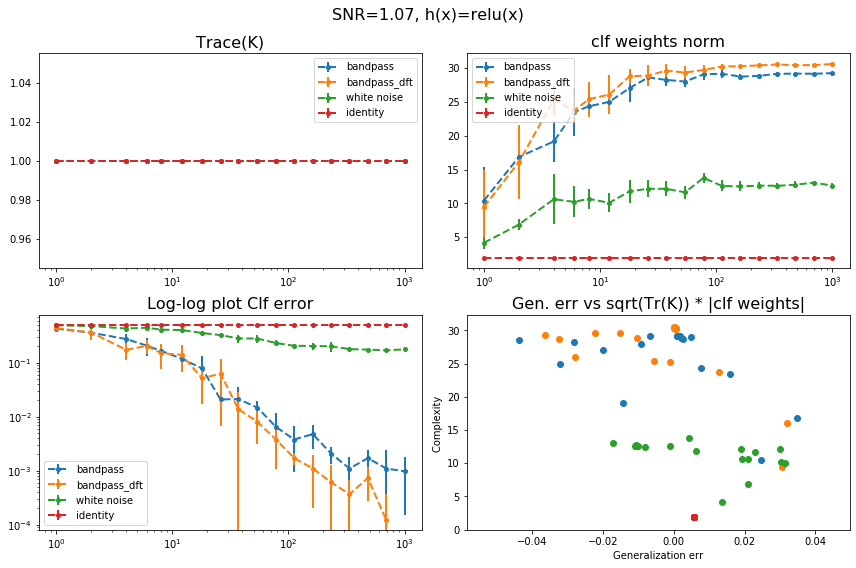

In [36]:
snr = a ** 2 / np.sqrt(1 - a**2)
plot_results(results, 'SNR=%0.2f, h(x)=relu(x)' % snr)
plt.savefig('figures/rand_classification/dft_data/clf_dim_relu_nonlin.png')

__Compare the performance and PR dimension of bandpass weights with different non-linearities__

In [37]:
%%time 
f_gaus = lambda M, N: bp_weights_dft(M, N, lowcut=k - 3, highcut=k + 3)


non_lins = [('relu', relu), ('xsq', lambda x : x ** 2), ('id', lambda x: x)]
# ('cosine', lambda x: np.cos(x + np.random.uniform(-np.pi, np.pi, size=x.shape[1])))
results = {nl:[] for (nl, func) in non_lins}
for n in n_features:
    for (nl, h) in non_lins:
        params = {'width': n, 'weights': 'bandpass gaus', 'weight_fun': f_gaus, 'nonlinearity': h}
        lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, 
                                            y_test) for _ in range(5)]
        results[nl].append(np.real(dask.compute(*lazy_results)))

CPU times: user 11.9 s, sys: 4 s, total: 15.9 s
Wall time: 1min 5s


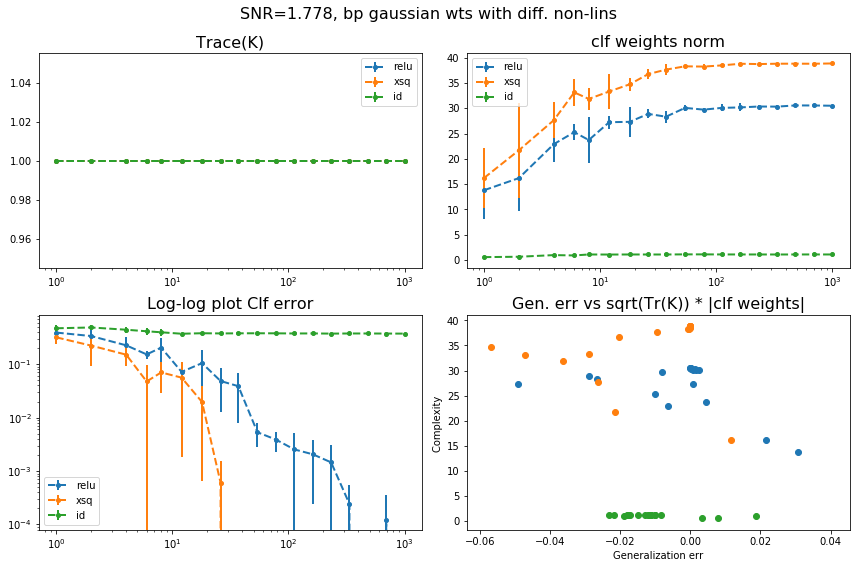

In [38]:
snr = a ** 2 / (1 - a ** 2)
plot_results(results, 'SNR=%0.3f, bp gaussian wts with diff. non-lins' % snr)
plt.savefig('figures/rand_classification/dft_data/clf_dim_bpgaus_nonlin_a=%0.2f.png' % a)

In [ ]:
r = np.array(results['relu'])
r[:, :, 2] - r[:, :, 3]